In [97]:
# Install necessary libraries
# ========================================================
!pip install folium networkx geopandas osmnx matplotlib

# Import libraries
# ========================================================
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap, MarkerCluster
import geopandas as gpd
import networkx as nx
import osmnx as ox
import unicodedata
from geopy.distance import geodesic
import random
import matplotlib.pyplot as plt


In [98]:
# Part 1: Data Preparation
# ========================================================

# Step 1.1: Load the EV charging station dataset
df = pd.read_csv('Quebec_EV_charging_station.csv')

# Step 1.2: Normalize the 'City' column by removing accents and converting to lowercase
df['City'] = df['City'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore').decode('utf-8').lower())

# Step 1.3: Filter for rows where 'City' is 'montreal' and select relevant columns
montreal_df = df[df['City'] == 'montreal']
montreal_df = montreal_df[['City', 'Latitude', 'Longitude', 'Price', 'Pricing']]

# Step 1.4: Save the filtered dataset for future use
output_path = 'Montreal_EV_charging_stations.csv'
if not montreal_df.empty:
    montreal_df.to_csv(output_path, index=False)
else:
    print("No data found for 'Montreal' in the dataset after cleaning.")

In [99]:
# Part 2: Visualization with Folium
# ========================================================

# Step 2.1: Initialize a map centered on Montreal
montreal_map = folium.Map(location=[45.5017, -73.5673], zoom_start=12)

# Step 2.2: Add markers for each charging station with color coding based on price
for index, row in montreal_df.iterrows():
    marker_color = "orange" if row['Price'] > 1 else "blue"
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Price: {row['Price']}, Pricing: {row['Pricing']}",
        icon=folium.Icon(color=marker_color, icon="bolt", prefix="fa")
    ).add_to(montreal_map)

# Step 2.3: Add Heatmap for Charging Stations
heat_data = [[row['Latitude'], row['Longitude']] for _, row in montreal_df.iterrows()]
HeatMap(heat_data).add_to(montreal_map)

In [100]:
# Part 3: Spatial Analysis with GeoPandas
# ========================================================

# Step 3.1: Create a GeoDataFrame for spatial analysis
gdf = gpd.GeoDataFrame(
    montreal_df,
    geometry=gpd.points_from_xy(montreal_df['Longitude'], montreal_df['Latitude']),
    crs="EPSG:4326"
)

# Step 3.2: Convert to a projected CRS for accurate buffer calculations and create a 500-meter buffer
gdf = gdf.to_crs(epsg=3395)
gdf['buffer'] = gdf.geometry.buffer(500)

# Step 3.3: Add buffer zones to the map
for _, row in gdf.iterrows():
    buffer_coords = list(row['buffer'].exterior.coords)
    buffer_locations = [(coord[1], coord[0]) for coord in buffer_coords]
    folium.Polygon(
        locations=buffer_locations,
        color="green",
        fill=True,
        fill_opacity=0.3
    ).add_to(montreal_map)

In [101]:
# Part 4: Network Analysis with OSMnx
# ========================================================

# Step 4.1: Load Montreal's road network
montreal_graph = ox.graph_from_place("Montreal, Quebec, Canada", network_type="drive")

# Step 4.2: Add edge lengths for network analysis
montreal_graph = ox.distance.add_edge_lengths(montreal_graph)

# Step 4.3: Retain only the largest connected component for consistency
montreal_graph = montreal_graph.subgraph(max(nx.strongly_connected_components(montreal_graph), key=len)).copy()

# Step 4.4: Find the nearest road network nodes for each charging station
nodes = []
for _, row in montreal_df.iterrows():
    try:
        nearest_node = ox.distance.nearest_nodes(
            montreal_graph, X=row['Longitude'], Y=row['Latitude']
        )
        nodes.append(nearest_node)
    except Exception as e:
        print(f"Error finding nearest node for charging station at ({row['Latitude']}, {row['Longitude']}): {e}")

# Step 4.5: Define a sample location (Downtown Montreal) and find its nearest node
sample_location = (45.5088, -73.554)
try:
    sample_node = ox.distance.nearest_nodes(
        montreal_graph, X=sample_location[1], Y=sample_location[0]
    )
except Exception as e:
    print(f"Error finding nearest node for sample location: {e}")
    sample_node = None

# Step 4.6: Calculate shortest paths from the sample location to each charging station
shortest_paths = {}
if sample_node is not None:
    for i, node in enumerate(nodes):
        try:
            if nx.has_path(montreal_graph, sample_node, node):
                path_length = nx.shortest_path_length(
                    montreal_graph, source=sample_node, target=node, weight="length"
                )
                shortest_paths[f"Station {i+1}"] = path_length
            else:
                print(f"Station {i+1}: Node {node} not reachable from sample location.")
        except Exception as e:
            print(f"Error calculating shortest path to Station {i+1}: {e}")

# Display shortest path results
if shortest_paths:
    print("Shortest path lengths (meters) from the sample location to each charging station:")
    for station, distance in shortest_paths.items():
        print(f"{station}: {distance:.2f} meters")
else:
    print("No shortest paths calculated.")

Shortest path lengths (meters) from the sample location to each charging station:
Station 1: 12002.76 meters
Station 2: 12002.76 meters
Station 3: 13662.77 meters
Station 4: 13662.77 meters
Station 5: 14288.15 meters
Station 6: 14288.15 meters
Station 7: 14003.94 meters
Station 8: 14003.94 meters
Station 9: 13186.74 meters
Station 10: 13186.74 meters
Station 11: 13186.74 meters
Station 12: 13186.74 meters
Station 13: 13806.40 meters
Station 14: 13806.40 meters
Station 15: 13806.40 meters
Station 16: 13806.40 meters
Station 17: 13806.40 meters
Station 18: 13806.40 meters
Station 19: 13806.40 meters
Station 20: 13806.40 meters
Station 21: 15271.78 meters
Station 22: 15271.78 meters
Station 23: 12945.72 meters
Station 24: 12945.72 meters
Station 25: 11900.70 meters
Station 26: 11900.70 meters
Station 27: 11900.70 meters
Station 28: 11900.70 meters
Station 29: 10992.14 meters
Station 30: 10992.14 meters
Station 31: 12400.96 meters
Station 32: 12400.96 meters
Station 33: 12367.18 meters
Sta

Original Traffic Flow Data:
   longitude   latitude traffic_source  x2024_02_13  x2024_02_14  x2024_02_15  \
0 -73.573707  45.541155       Montreal        326.0        210.0        210.0   
1 -73.605007  45.533979       Montreal       1078.0        795.0        786.0   
2 -73.623170  45.523450       Montreal        894.0        634.0        673.0   
3 -73.597670  45.462930       Montreal        340.0        252.0        317.0   
4 -73.605530  45.523730       Montreal        440.0        529.0        549.0   

   x2024_02_16  x2024_02_17  x2024_02_18  x2024_02_19  ...  x2024_03_05  \
0        240.0        239.0        161.0        236.0  ...        241.0   
1        928.0        665.0        376.0        503.0  ...        823.0   
2        360.0        664.0        624.0        570.0  ...        660.0   
3        216.0        284.0        278.0        213.0  ...        407.0   
4        512.0        599.0        708.0        633.0  ...        375.0   

   x2024_03_06  x2024_03_07  x2024

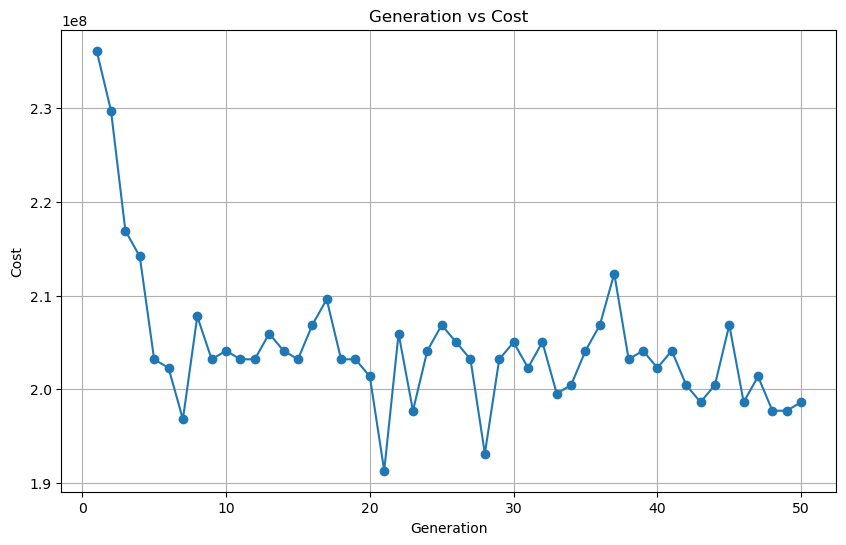

In [102]:
# Part 5: Traffic Flow Analysis and Optimization
# ========================================================

# Step 5.1: Load existing EV charging station and traffic flow data
ev_stations = pd.read_csv('Montreal_EV_charging_stations.csv')
traffic_flow = pd.read_csv('Montreal_traffic_flow.csv')

# Step 5.2: Inspect and filter the traffic flow data
print("Original Traffic Flow Data:")
print(traffic_flow.head())

filtered_traffic_flow = traffic_flow[
    (traffic_flow['average_vehicle_count'].notnull()) &
    (traffic_flow['average_vehicle_count'] > 0)
]

print("Filtered Traffic Flow Data:")
print(filtered_traffic_flow.head())

# Step 5.3: Extract coordinates and demand
traffic_nodes = filtered_traffic_flow[['latitude', 'longitude']].values
vehicle_counts = filtered_traffic_flow['average_vehicle_count'].values

# Step 5.4: Filter for Montreal charging stations
ev_stations = ev_stations[ev_stations['City'].str.lower() == 'montreal']
ev_stations = ev_stations[['Latitude', 'Longitude']].values

# Step 5.5: Define parameters for optimization
deployment_cost = 1000
station_capacity = 500
service_radius = 5
over_demand_penalty = 10

# Step 5.6: Define distance function
def compute_distance(coord1, coord2):
    return geodesic(coord1, coord2).km

# Step 5.7: Evaluate cost function
def evaluate_cost(chromosome, traffic_nodes, vehicle_counts, ev_stations):
    total_cost = 0
    for i, deploy in enumerate(chromosome):
        if deploy == 1:
            total_cost += deployment_cost
            for j, traffic_node in enumerate(traffic_nodes):
                try:
                    distance = min(precomputed_distances[j])
                    if distance <= service_radius:
                        total_cost += distance * vehicle_counts[j]
                        if vehicle_counts[j] > station_capacity:
                            total_cost += over_demand_penalty * (vehicle_counts[j] - station_capacity)
                except Exception as e:
                    print(f"Error at node {j}: {e}")
    return total_cost

# Step 5.8: Initialize population for genetic algorithm
def initialize_population(pop_size, num_nodes):
    return [np.random.randint(0, 2, size=num_nodes) for _ in range(pop_size)]

# Step 5.9: Selection (tournament selection)
def select_parents(population, fitness, k=3):
    selected = []
    for _ in range(2):
        indices = np.random.choice(len(population), k, replace=False)
        selected.append(population[min(indices, key=lambda idx: fitness[idx])])
    return selected

# Step 5.10: Crossover (single-point crossover)
def crossover(parent1, parent2):
    point = random.randint(1, len(parent1) - 1)
    child1 = np.concatenate([parent1[:point], parent2[point:]])
    child2 = np.concatenate([parent2[:point], parent1[point:]])
    return child1, child2

# Step 5.11: Mutation (bit-flip mutation)
def mutate(chromosome, mutation_rate=0.1):
    for i in range(len(chromosome)):
        if random.random() < mutation_rate:
            chromosome[i] = 1 - chromosome[i]
    return chromosome

# Step 5.12: Precompute distances between traffic nodes and EV stations
def precompute_distances(traffic_nodes, ev_stations):
    distances = np.zeros((len(traffic_nodes), len(ev_stations)))
    for i, traffic_node in enumerate(traffic_nodes):
        for j, ev_station in enumerate(ev_stations):
            distances[i, j] = compute_distance(traffic_node, ev_station)
    return distances

# Precompute distances once
precomputed_distances = precompute_distances(traffic_nodes, ev_stations)

# Step 5.13: Genetic Algorithm
def genetic_algorithm(pop_size, num_generations, num_nodes, mutation_rate=0.1):
    population = initialize_population(pop_size, num_nodes)
    best_solution, best_cost = None, float('inf')
    cost_history = []

    for generation in range(num_generations):
        fitness = [evaluate_cost(chromosome, traffic_nodes, vehicle_counts, ev_stations) for chromosome in population]
        
        gen_best_cost = min(fitness)
        gen_best_solution = population[np.argmin(fitness)]
        cost_history.append(gen_best_cost)
        
        if gen_best_cost < best_cost:
            best_cost, best_solution = gen_best_cost, gen_best_solution

        new_population = []
        while len(new_population) < pop_size:
            parent1, parent2 = select_parents(population, fitness)
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)
            new_population.extend([child1, child2])

        population = new_population[:pop_size]

    return best_solution, best_cost, cost_history

# Run Genetic Algorithm
num_nodes = len(traffic_nodes)
best_solution, best_cost, cost_history = genetic_algorithm(pop_size=20, num_generations=50, num_nodes=num_nodes)
print("Best Solution:", best_solution)
print("Best Cost:", best_cost)

# Plot generation vs cost
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cost_history) + 1), cost_history, marker='o')
plt.title('Generation vs Cost')
plt.xlabel('Generation')
plt.ylabel('Cost')
plt.grid(True)
plt.show()

In [103]:
# Part 6: Visualization of Results
# ========================================================

# Step 6.1: Initialize map for visualization
montreal_center = [45.5017, -73.5673]
m = folium.Map(location=montreal_center, zoom_start=12)

# Step 6.2: Add traffic nodes (filtered traffic flow data)
traffic_cluster = MarkerCluster(name="Traffic Nodes").add_to(m)
for _, row in filtered_traffic_flow.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='red',
        fill=True,
        fill_opacity=0.6,
        tooltip=f"Traffic Node: Avg Vehicles = {row['average_vehicle_count']}"
    ).add_to(traffic_cluster)

# Step 6.3: Add existing EV charging stations
for station in ev_stations:
    folium.Marker(
        location=station,
        icon=folium.Icon(color='blue', icon='info-sign'),
        tooltip="Existing EV Charging Station"
    ).add_to(m)

# Step 6.4: Add new EV charging stations selected by the genetic algorithm
for idx, is_selected in enumerate(best_solution):
    if is_selected == 1:
        folium.Marker(
            location=traffic_nodes[idx],
            icon=folium.Icon(color='green', icon='bolt'),
            tooltip="New EV Charging Station"
        ).add_to(m)

# Step 6.5: Add a legend to the map
folium.LayerControl().add_to(m)

# Step 6.6: Show the map
m

Modified Best Solution: [0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0
 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0 1 0 0
 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 1 0 0 0 1 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1 0
 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1
 1 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0
 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0
 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 

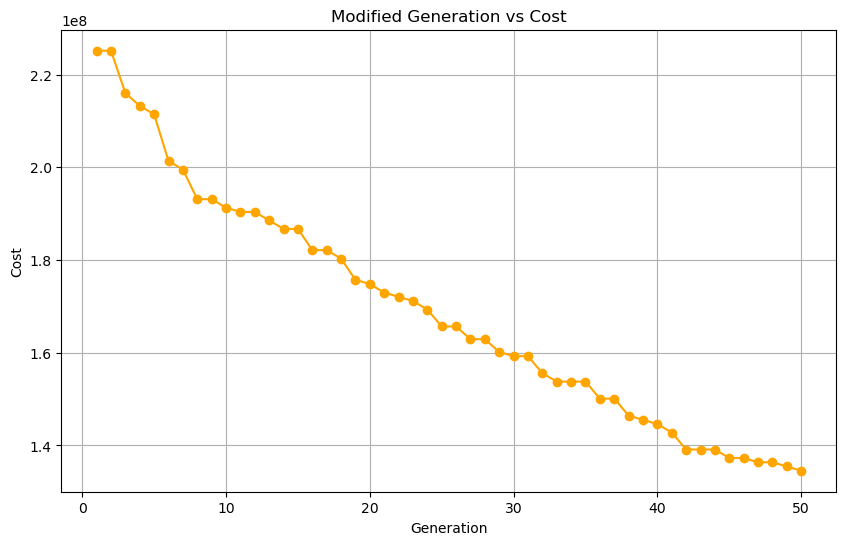

In [106]:
# Part 7: Modified Genetic Algorithm with Reduced Fluctuations
# ========================================================

# Step 7.1: Modified Genetic Algorithm
def modified_genetic_algorithm(pop_size, num_generations, num_nodes, mutation_rate=0.01, elite_size=2):
    population = initialize_population(pop_size, num_nodes)
    best_solution, best_cost = None, float('inf')
    cost_history = []

    for generation in range(num_generations):
        fitness = [evaluate_cost(chromosome, traffic_nodes, vehicle_counts, ev_stations) for chromosome in population]
        
        # Track the best cost in the current generation
        gen_best_cost = min(fitness)
        gen_best_solution = population[np.argmin(fitness)]
        cost_history.append(gen_best_cost)
        
        if gen_best_cost < best_cost:
            best_cost, best_solution = gen_best_cost, gen_best_solution

        # Elitism: Retain the best solutions
        sorted_population = [x for _, x in sorted(zip(fitness, population), key=lambda pair: pair[0])]
        new_population = sorted_population[:elite_size]

        # Generate new offspring
        while len(new_population) < pop_size:
            parent1, parent2 = select_parents(population, fitness)
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)
            new_population.extend([child1, child2])

        population = new_population[:pop_size]

    return best_solution, best_cost, cost_history

# Run Modified Genetic Algorithm
best_solution_mod, best_cost_mod, cost_history_mod = modified_genetic_algorithm(pop_size=20, num_generations=50, num_nodes=num_nodes)
print("Modified Best Solution:", best_solution_mod)
print("Modified Best Cost:", best_cost_mod)

# Plot generation vs cost for modified GA
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cost_history_mod) + 1), cost_history_mod, marker='o', color='orange')
plt.title('Modified Generation vs Cost')
plt.xlabel('Generation')
plt.ylabel('Cost')
plt.grid(True)
plt.show()


In [ ]:
# Step 7.2: Modified Genetic Algorithm
def modified_genetic_algorithm(pop_size, num_generations, num_nodes, mutation_rate=0.05, elite_size=2):
    population = initialize_population(pop_size, num_nodes)
    best_solution, best_cost = None, float('inf')
    cost_history = []

    for generation in range(num_generations):
        fitness = [evaluate_cost(chromosome, traffic_nodes, vehicle_counts, ev_stations) for chromosome in population]
        
        # Track the best cost in the current generation
        gen_best_cost = min(fitness)
        gen_best_solution = population[np.argmin(fitness)]
        cost_history.append(gen_best_cost)
        
        if gen_best_cost < best_cost:
            best_cost, best_solution = gen_best_cost, gen_best_solution

        # Elitism: Retain the best solutions
        sorted_population = [x for _, x in sorted(zip(fitness, population), key=lambda pair: pair[0])]
        new_population = sorted_population[:elite_size]

        # Generate new offspring
        while len(new_population) < pop_size:
            parent1, parent2 = select_parents(population, fitness)
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)
            new_population.extend([child1, child2])

        population = new_population[:pop_size]

    return best_solution, best_cost, cost_history

# Run Modified Genetic Algorithm
best_solution_mod, best_cost_mod, cost_history_mod = modified_genetic_algorithm(pop_size=20, num_generations=50, num_nodes=num_nodes)
print("Modified Best Solution:", best_solution_mod)
print("Modified Best Cost:", best_cost_mod)

# Plot generation vs cost for modified GA
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cost_history_mod) + 1), cost_history_mod, marker='o', color='orange')
plt.title('Modified Generation vs Cost')
plt.xlabel('Generation')
plt.ylabel('Cost')
plt.grid(True)
plt.show()